In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import seaborn as sns

In [47]:
INPUT_TRAIN = '../input/train.csv'
INPUT_TEST = '../input/test.csv'
OUTPUT_SUBMIT = '../output/submit_v2.csv'

In [48]:
def calculation_distance(x_1, y_1, x_2, y_2):
    # 赤道半径 (km)
    R = 6371
    # Radian角に変換
    _x1, _y1, _x2, _y2  = map(np.radians, [x_1, y_1, x_2, y_2])
    
    delta_x = _x2 - _x1
    delta_y = _y2 - _y1
    
    # 距離を計算
    a = np.sin(delta_y/2.0)**2 + np.cos(_y1) * np.cos(_y2) * np.sin(delta_x/2.0)**2
    return 2 * R * np.arcsin(np.sqrt(a))

def calculation_azimuth(x_1, y_1, x_2, y_2):
    # Radian角に修正
    _x1, _y1, _x2, _y2 = map(np.radians, [x_1, y_1, x_2, y_2])
    
    delta_x = _x2 - _x1
    _y = np.sin(delta_x)
    _x = np.cos(_y1) * np.tan(_y2) - np.sin(_y1) * np.cos(delta_x)

    psi = np.rad2deg(np.arctan2(_y, _x))
    
    return np.where(psi < 0, 360 + psi, psi)

def outlier_iqr(df, columns=None):
    if columns == None:
        columns = df.columns

    for col in columns:
        q1 = df[col].describe()['25%']
        q3 = df[col].describe()['75%']
        #四分位範囲
        iqr = q3 - q1 
        
        outlier_min = q1 - iqr * 1.5
        outlier_max = q3 + iqr * 1.5

        df = df[(df[col] >= outlier_min) & (df[col] <= outlier_max)]
        
    return df

In [49]:
def preprocessing(df, isTrainData=True):
    print('before dropna:{}'.format(df.shape))
    df = df.dropna()
    print('after dropna:{}'.format(df.shape))
    
    # fare_amount
    if 'fare_amount' in df.columns:
        df = df[df['fare_amount'] > 0]
        print('after fare_amount > 0:{}'.format(df.shape))

        df = outlier_iqr(df, columns=['fare_amount'])
        print('after outlier_iqr:{}'.format(df.shape))
    
    # latitude and longitude
    if isTrainData:
        df = df[(df['pickup_longitude'] > -75) & (df['pickup_longitude'] < -73)]
        df = df[(df['pickup_latitude'] > 40) & (df['pickup_latitude'] < 42)]
        df = df[(df['dropoff_longitude'] > -75) & (df['dropoff_longitude'] < -73)]
        df = df[(df['dropoff_latitude'] > 40) & (df['dropoff_latitude'] < 42)]
        print('after narrrowing location:{}'.format(df.shape))
    
    # passenger count
    df = df[df['passenger_count'] > 0]
    print('after passenger count > 0:{}'.format(df.shape))
    
    # add new feature from latitude and longitude
    df['distance'] = calculation_distance(df['pickup_longitude'],
                                      df['pickup_latitude'],
                                      df['dropoff_longitude'],
                                      df['dropoff_latitude'])
    df['azimuth'] = calculation_azimuth(df['pickup_longitude'],
                                      df['pickup_latitude'],
                                      df['dropoff_longitude'],
                                      df['dropoff_latitude'])
    print('after adding distance and azimuth:{}'.format(df.shape))
    
    # modify pickup_datetime
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S UTC')
    
    df['hour'] = df['pickup_datetime'].dt.hour
    df['day'] = df['pickup_datetime'].dt.day
    df['month'] = df['pickup_datetime'].dt.month
    df['dayofweek'] = df['pickup_datetime'].dt.dayofweek
    df['year'] = df['pickup_datetime'].dt.year
    print('after updating pickup_datetime:{}'.format(df.shape))
    
    return df

# Load Test Data

In [50]:
df_test = pd.read_csv(INPUT_TEST)
df_test = preprocessing(df_test, isTrainData=False)
df_test.head()

before dropna:(9914, 7)
after dropna:(9914, 7)
after passenger count > 0:(9914, 7)
after adding distance and azimuth:(9914, 9)
after updating pickup_datetime:(9914, 14)


,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,azimuth,hour,day,month,dayofweek,year
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24,-73.973320,40.763805,-73.981430,40.743835,1,2.323260,197.102591,13,27,1,1,2015
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24,-73.986862,40.719383,-73.998886,40.739201,1,2.425353,335.311613,13,27,1,1,2015
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44,-73.982524,40.751260,-73.979654,40.746139,1,0.618628,156.994148,11,8,10,5,2011
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12,-73.981160,40.767807,-73.990448,40.751635,1,1.961033,203.513308,21,1,12,5,2012
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12,-73.966046,40.789775,-73.988565,40.744427,1,5.387301,200.618451,21,1,12,5,2012


# Load Train Data

In [51]:
df_train = pd.read_csv(INPUT_TRAIN, nrows=1_000_000)
#df_train = pd.read_csv(INPUT_TRAIN) # 永遠におわらない
df_train = preprocessing(df_train, isTrainData=True)
df_train.head()

before dropna:(1000000, 8)
after dropna:(999990, 8)
after fare_amount > 0:(999923, 8)
after outlier_iqr:(913433, 8)
after narrrowing location:(894767, 8)
after passenger count > 0:(891386, 8)
after adding distance and azimuth:(891386, 10)
after updating pickup_datetime:(891386, 15)


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,azimuth,hour,day,month,dayofweek,year
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,1.030764,167.240469,17,15,6,0,2009
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,8.450134,21.498365,16,5,1,1,2010
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,1.389525,211.033211,0,18,8,3,2011
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,2.799270,352.327836,4,21,4,5,2012
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,1.999157,28.802783,7,9,3,1,2010


# Modeling

In [52]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [53]:
X = df_train.drop(columns=['key', 'fare_amount', 'pickup_datetime'])
y = df_train['fare_amount']

print(X.shape)
print(y.shape)

(891386, 12)
(891386,)


In [54]:
X_pred = df_test.drop(columns=['key','pickup_datetime'])
print(X_pred.shape)

(9914, 12)


In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(713108, 12)
(178278, 12)
(713108,)
(178278,)


In [56]:
params = {
    'silent' : 1,
    'max_depth' : 6,
    'min_child_weight' : 1,
    'eta' : 0.1,
    'tree_method' : 'exact',
    'objective' : 'reg:linear',
    'eval_metric' : 'rmse',
    'predictor' : 'cpu_predictor'
}

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


# hyper parameter turning

In [57]:
gridsearch_params = [
    (max_depth, eta)
    for max_depth in [6, 7, 8]
    for eta in [0.1, 0.05, 0.01]
]
gridsearch_params

[(6, 0.1),
 (6, 0.05),
 (6, 0.01),
 (7, 0.1),
 (7, 0.05),
 (7, 0.01),
 (8, 0.1),
 (8, 0.05),
 (8, 0.01)]

In [58]:
min_rmse = float('inf')
best_param = []

for max_depth, eta in gridsearch_params:
    print('max_depth={}, eta={}'.format(max_depth, eta))
    
    params['max_depth'] = max_depth
    params['eta'] = eta
    
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=1000, # TODO: 1000 にする
        seed=0,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=5
    )
    
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].idxmin()
    print('  RMSE {} for {} rounds'.format(mean_rmse, boost_rounds))
    
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_param = (max_depth, eta)
        
print('\nBest parmas {}, RMSE {}'.format(best_param, min_rmse))

max_depth=6, eta=0.1
  RMSE 1.756682 for 972 rounds
max_depth=6, eta=0.05
  RMSE 1.7694144 for 999 rounds
max_depth=6, eta=0.01
  RMSE 1.842508 for 999 rounds
max_depth=7, eta=0.1
  RMSE 1.7478848 for 816 rounds
max_depth=7, eta=0.05
  RMSE 1.7549202000000002 for 905 rounds
max_depth=7, eta=0.01
  RMSE 1.81402 for 999 rounds
max_depth=8, eta=0.1
  RMSE 1.7423452000000001 for 570 rounds
max_depth=8, eta=0.05
  RMSE 1.7404863999999995 for 996 rounds
max_depth=8, eta=0.01
  RMSE 1.7903692 for 999 rounds

Best parmas (8, 0.05), RMSE 1.7404863999999995


In [59]:
# learning again by best params
params['max_depth'] = best_param[0]
params['eta'] = best_param[1]

model = xgb.train(params=params,
                 dtrain=dtrain,
                 num_boost_round=1000,
                 early_stopping_rounds=5,
                 evals=[(dtest, 'test')])

[0]	test-rmse:8.94084
Will train until test-rmse hasn't improved in 5 rounds.
[1]	test-rmse:8.51818
[2]	test-rmse:8.1177
[3]	test-rmse:7.73837
[4]	test-rmse:7.37916
[5]	test-rmse:7.03907
[6]	test-rmse:6.71739
[7]	test-rmse:6.41304
[8]	test-rmse:6.12506
[9]	test-rmse:5.8529
[10]	test-rmse:5.59577
[11]	test-rmse:5.35307
[12]	test-rmse:5.1238
[13]	test-rmse:4.90756
[14]	test-rmse:4.70375
[15]	test-rmse:4.51152
[16]	test-rmse:4.33061
[17]	test-rmse:4.16023
[18]	test-rmse:4.00019
[19]	test-rmse:3.85
[20]	test-rmse:3.70891
[21]	test-rmse:3.57668
[22]	test-rmse:3.45244
[23]	test-rmse:3.33655
[24]	test-rmse:3.22813
[25]	test-rmse:3.12676
[26]	test-rmse:3.03219
[27]	test-rmse:2.94424
[28]	test-rmse:2.86212
[29]	test-rmse:2.78583
[30]	test-rmse:2.71493
[31]	test-rmse:2.64925
[32]	test-rmse:2.58812
[33]	test-rmse:2.53149
[34]	test-rmse:2.47896
[35]	test-rmse:2.43029
[36]	test-rmse:2.38549
[37]	test-rmse:2.34388
[38]	test-rmse:2.30527
[39]	test-rmse:2.26973
[40]	test-rmse:2.23715
[41]	test-rmse:2.

[345]	test-rmse:1.74758
[346]	test-rmse:1.74759
[347]	test-rmse:1.74759
[348]	test-rmse:1.74759
[349]	test-rmse:1.74751
[350]	test-rmse:1.74742
[351]	test-rmse:1.74726
[352]	test-rmse:1.74687
[353]	test-rmse:1.74675
[354]	test-rmse:1.74646
[355]	test-rmse:1.74647
[356]	test-rmse:1.74639
[357]	test-rmse:1.74631
[358]	test-rmse:1.74601
[359]	test-rmse:1.74593
[360]	test-rmse:1.74561
[361]	test-rmse:1.74561
[362]	test-rmse:1.74561
[363]	test-rmse:1.74549
[364]	test-rmse:1.74546
[365]	test-rmse:1.74531
[366]	test-rmse:1.74523
[367]	test-rmse:1.74513
[368]	test-rmse:1.74514
[369]	test-rmse:1.74513
[370]	test-rmse:1.74493
[371]	test-rmse:1.74484
[372]	test-rmse:1.74465
[373]	test-rmse:1.74458
[374]	test-rmse:1.7441
[375]	test-rmse:1.74377
[376]	test-rmse:1.74359
[377]	test-rmse:1.74354
[378]	test-rmse:1.74346
[379]	test-rmse:1.74347
[380]	test-rmse:1.74331
[381]	test-rmse:1.74303
[382]	test-rmse:1.74293
[383]	test-rmse:1.7427
[384]	test-rmse:1.74272
[385]	test-rmse:1.74224
[386]	test-rmse:1.

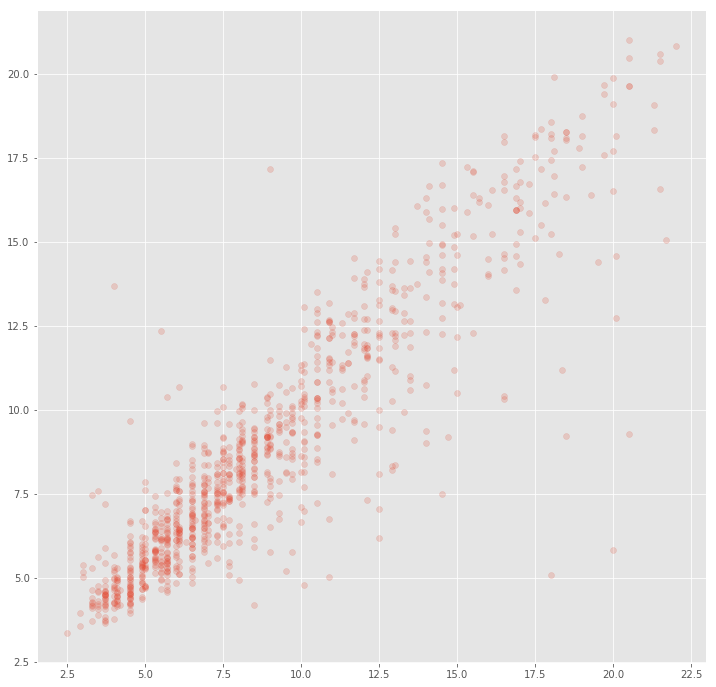

In [60]:
# prediction
prediction = model.predict(xgb.DMatrix(X_test),
                                        ntree_limit=model.best_ntree_limit)
plt.figure(figsize=(12,12))
plt.scatter(y_test[:1000], prediction[:1000], alpha=0.2)
plt.show()

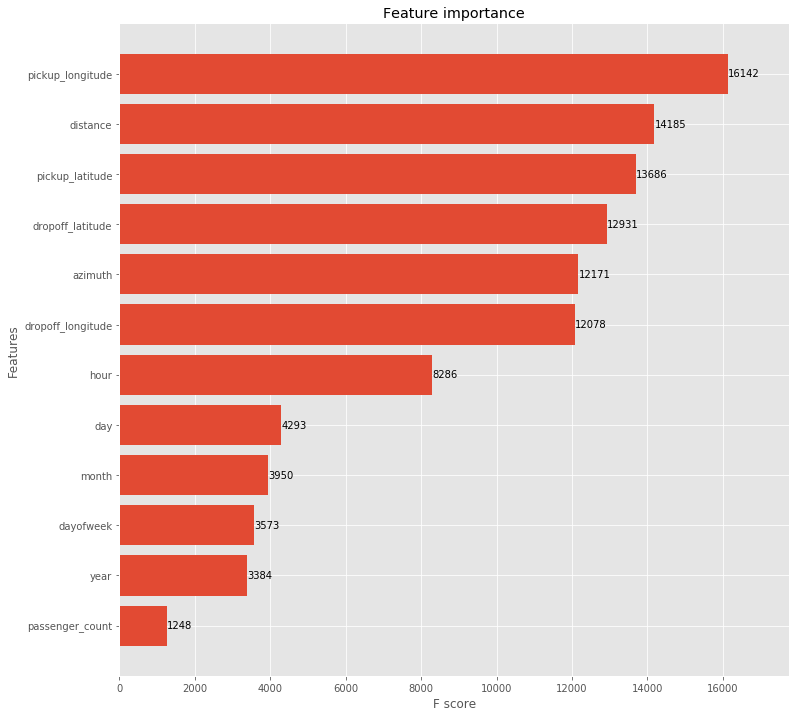

In [61]:
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, max_num_features=12, height=0.8, ax=ax)
plt.show()

In [62]:
pred = model.predict(xgb.DMatrix(X_pred),
                     ntree_limit=model.best_ntree_limit)
print(pred.shape)

(9914,)


In [63]:
df_test['fare_amount'] = pred
df_test[['key','fare_amount']].to_csv(OUTPUT_SUBMIT, index=False)